### **Overview**
This notebook will explore Portfolio Algorthmic Trading, using the Moving Average Convergence Divergence strategy in Python. Our selected stock is AAPL (Apple).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### **Extracting AAPL Financial Data**

In [2]:
# Extrract AAPL Financial Data

aapl = yf.download(tickers='AAPL', period = '1y', index_as_date = True, interval='1d')
aapl.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-12,86.180000,86.949997,83.555000,84.699997,84.133095,200146000
2020-06-15,83.312500,86.419998,83.144997,85.747498,85.173584,138808800
2020-06-16,87.864998,88.300003,86.180000,88.019997,87.430885,165428800
2020-06-17,88.787498,88.849998,87.772499,87.897499,87.309204,114406400
2020-06-18,87.852501,88.362503,87.305000,87.932503,87.343979,96820400
2020-06-19,88.660004,89.139999,86.287498,87.430000,86.844833,264476000
2020-06-22,87.834999,89.864998,87.787498,89.717499,89.117027,135445200
2020-06-23,91.000000,93.095001,90.567497,91.632500,91.019203,212155600
2020-06-24,91.250000,92.197502,89.629997,90.014999,89.412537,192623200


### Plotting the AAPL Price Charts

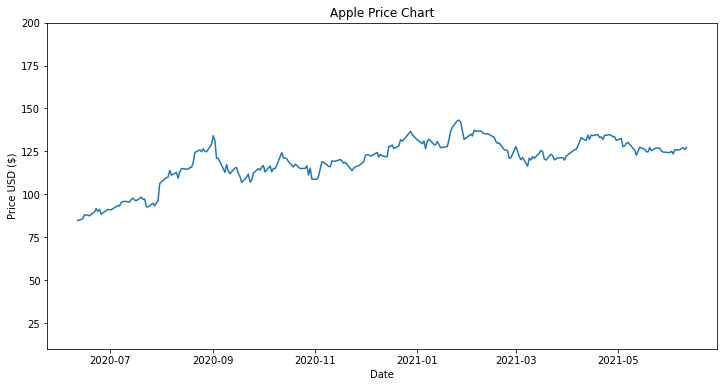

In [3]:
fig = plt.figure(figsize=(12, 6))
plt.plot(aapl['Close'], label='Close')
plt.title('Apple Price Chart')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.ylim([10, 200])
plt.show()

### Calculating EMAs, MACD & Signal 

In [4]:
# Functions to calculate EMAs, MACD & Signal Line
def calculate_shortEMA(dataframe):
    ShortEMA = dataframe.Close.ewm(span=12, adjust=False).mean()
    return ShortEMA

def calculate_longEMA(dataframe):
    LongEMA = dataframe.Close.ewm(span=26, adjust=False).mean()
    return LongEMA

def calculate_MACD(dataframe):
    MACD = calculate_longEMA(dataframe) - calculate_shortEMA(dataframe)
    return MACD

def calculate_signal(dataframe):
    signal = calculate_MACD(dataframe).ewm(span=9, adjust=False).mean()
    return signal

### Plotting the graphs

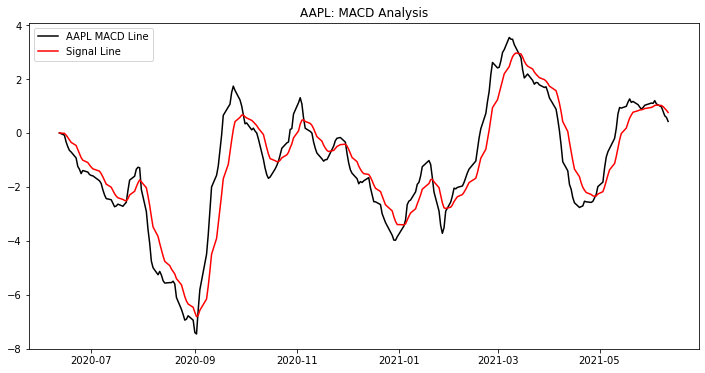

In [5]:
# Plotting the MACD indicator for AAPL
fig = plt.figure(figsize=(12, 6))
plt.plot(aapl.index, calculate_MACD(aapl), label = "AAPL MACD Line", color = 'black')
plt.plot(aapl.index, calculate_signal(aapl), label = 'Signal Line', color = 'red')
plt.legend(loc='upper left')
plt.title("AAPL: MACD Analysis")
plt.show()

*The above chart clearly allows investors to recognize when the MACD line crosses over the signal line and indicate whether they should buy or sell the stock! It allows us to have the future trend of the stock.

In [6]:
# Apple: Create new columns

aapl['MACD'] = calculate_MACD(aapl)
aapl['Signal Line'] = calculate_signal(aapl)

### Function for long/short signals of an asset

In [7]:
# Function to signal long/short signals

def buy_sell(dataframe):
    Buy = []
    Sell = []
    Flag = -1 
            
    for i in range(0, len(dataframe)):
        # Go through each row to tell if the MACD line crosses the Signal Line
        if dataframe['MACD'][i] > dataframe['Signal Line'][i]:
            Sell.append(np.nan)
            if Flag != 1:
                Buy.append(dataframe['Close'][i])
                Flag = 1 #indicates we have been here
            else:
                Buy.append(np.nan)
                
        elif dataframe['MACD'][i] < dataframe['Signal Line'][i]:
            Buy.append(np.nan)
            if Flag != 0:
                Sell.append(dataframe['Close'][i])
                Flag = 0 #indicates we have been here
            else:
                Sell.append(np.nan)
        else:
            Sell.append(np.nan)
            Buy.append(np.nan)
            
    return (Buy, Sell)

In [8]:
aapl_signal = buy_sell(aapl)
aapl['Buy_Signal_Price'] = aapl_signal[0]
aapl['Sell_Signal_Price'] = aapl_signal[1]

### Plot the Final Signal Graphs

In [9]:
def plot_signals(dataframe):
    fig = plt.figure(figsize=(12, 6))
    plt.scatter(dataframe.index, dataframe['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha = 1)
    plt.scatter(dataframe.index, dataframe['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha = 1)
    plt.plot(dataframe['Close'], label='Close Price', color = 'black', alpha = 0.35)
    plt.title('Closing Price Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend(loc = 'upper left')
    plt.show()

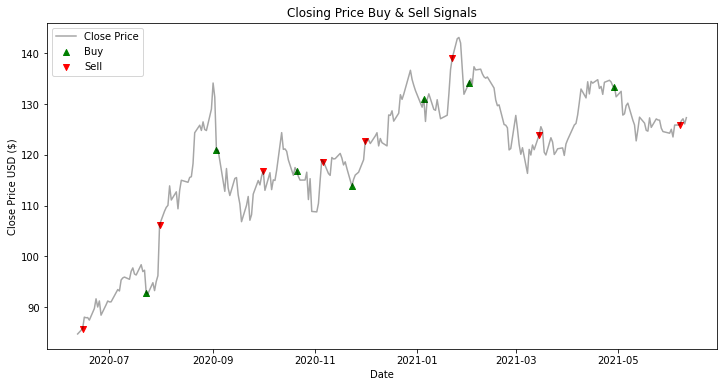

In [10]:
plot_signals(aapl)

### Backtesting
*Backtesting is a very popular term used in Statistical Analysis which refers to testing a predictive model on historical data.*

In [11]:
# Backtesting

def backtesting(dataframe):
    # Extract out the index of each Buy & Sell price 
    Buy = []
    Sell = []
    
    for i in range(len(dataframe['Buy_Signal_Price'])):
               if not np.isnan(dataframe['Buy_Signal_Price'][i]):
                   Buy.append(i)
                    
    for i in range(len(dataframe['Sell_Signal_Price'])):
               if not np.isnan(dataframe['Sell_Signal_Price'][i]):
                   Sell.append(i)
                                
    Realbuys = [i+1 for i in Buy] 
    Realsells = [i+1 for i in Sell]
    
    # Extract out the opening price for the day after the respective signals
    Buyprices = dataframe.Open.iloc[Realbuys]
    Sellprices = dataframe.Open.iloc[Realsells]
    
    # Drop the signals if the selling signal is preceeded with no buying signal
    # Applies for the signals if the buying signal is followed with no selling signal
    if Sellprices.index[0] < Buyprices.index[0]:
        Sellprices = Sellprices.drop(Sellprices.index[0])
    elif Buyprices.index[-1] > Sellprices.index[-1]:
        Buyprices = Buyprices.drop(Buyprices.index[-1])
        
    # Calculate relative profits 
    relative_profits = []
    for i in range(len(Sellprices)):
        relative_profits.append((Sellprices[i] - Buyprices[i])/Buyprices[i])
        return sum(relative_profits)/len(relative_profits) * 100

### Calculate Net Average Annualized Returns 

In [12]:
print("The MACD Algorithm was able to generate a {}% profit over the past year for Apple"
      .format(round(backtesting(aapl), 2)))

The MACD Algorithm was able to generate a 18.92% profit over the past year for Apple
